<a href="https://colab.research.google.com/github/LeszekBlazewski/MTSwM/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
%cd /content/gdrive/My Drive/Colab Notebooks/MTSwM

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/MTSwM


# Dataset classes andfeatures

In [2]:
dataset_classes = {
    1:"Pain of non-heart origin",
    2:"Angina prectoris",
    3:"Angina prectoris - prizmental variant",
    4:"Myocardial infraction (transmural)",
    5:"Myocardial infraction (subendocardial)"
}

dataset_features_columns = [
    'Age',
    'Sex',
    # Pain
    'Pain location', 
    'Chest pain radiation', 
    'Pain character', 
    'Onset of pain', 
    'Number of hours since onset', 
    'Duration of the last episode', 
    # Associated symptoms
    'Nausea', 
    'Diaphoresis',
    'Palpitations',
    'Dyspnea',
    'Dizziness/syncope',
    'Burping',
    # Palliative factors
    'Palliative factors',
    # History of similar pain
    'Prior chest pain of this type',
    'Physician consulted for prior pain',
    'Prior pain related to heart',
    'Prior pain due to MI',
    'Prior pain due to angina prectoris',
    # Past medical history
    'Prior MI',
    'Prior angina prectoris',
    'Prior atypical chest pain',
    'Congestive heart failure',
    'Peripheral vascular disease',
    'Hiatal hernia',
    'Hypertension',
    'Diabetes',
    'Smoker',
    # Current medication usage
    'Diuretics',
    'Nitrates',
    'Beta blockers',
    'Digitalis',
    'Nonsteroidal anti-inflammator',
    'Antacids/H2 blockers',
    # Physical examinations
    'Systolic blood pressure',
    'Diastolic blood pressure',
    'Heart rate',
    'Respiration rate',
    'Rales',
    'Cyanosis',
    'Pallor',
    'Systolic murmur',
    'Diastolic murmur',
    'Oedema',
    'S3 gallop',
    'S4 gallop',
    'Chest wall tenderness',
    'Diaphoresis',
    # ECG examination
    'New Q wave',
    'Any Q wave',
    'New ST segment elevation',
    'Any ST segment elevation',
    'New ST segment depression',
    'Any ST segment depression',
    'New T wave inversion',
    'Any T wave inversion',
    'New intraventricular conduction defect',
    'Any intraventricular conduction defect',
    'Class'
]

# Load & merge datasets

In [3]:
data_list = []

for i, file in enumerate(glob.glob("data/*.txt"), 1):
  data_set = pd.read_csv(file,sep="\t", header=None).transpose()
  data_set['Class'] = i
  data_list.append(data_set)

dataset = pd.concat(data_list, axis=0)

dataset.columns = dataset_features_columns

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901 entries, 0 to 262
Data columns (total 60 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   Age                                     901 non-null    int64
 1   Sex                                     901 non-null    int64
 2   Pain location                           901 non-null    int64
 3   Chest pain radiation                    901 non-null    int64
 4   Pain character                          901 non-null    int64
 5   Onset of pain                           901 non-null    int64
 6   Number of hours since onset             901 non-null    int64
 7   Duration of the last episode            901 non-null    int64
 8   Nausea                                  901 non-null    int64
 9   Diaphoresis                             901 non-null    int64
 10  Palpitations                            901 non-null    int64
 11  Dyspnea            

# Features ranking

## SelectKBest

In [4]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

def build_features_ranking(x, y, score_func):
    features_num = x.shape[1]
    k_best_selector = SelectKBest(score_func=score_func, k=features_num) 
    k_best_selector.fit(x, y)
    scores_ranking = [
        (name, round(score, 2))
        for name, score in zip(x.columns, k_best_selector.scores_)
    ]
    scores_ranking.sort(reverse=True, key=lambda x: x[1])
    return scores_ranking

In [5]:
def print_features_ranking_with_plot(features_ranking, used_score_func):
  print(f'Features ranking after using {used_score_func} score function:')
  for i, feature in enumerate(features_ranking, 1):
    print(f"{i}. {feature[0]} {feature[1]}")
  # display bar plot
  plt.figure(figsize=(30,20))
  estimator_num = len(features_ranking)
  # sort ascending because horizontal bars print in reverse order
  ascending_features = sorted([(f[0], f[1]) for f in features_ranking], key=lambda f: f[1])
  plt.barh(range(estimator_num), [feature[1] for feature in ascending_features], align='center') # extract score value
  plt.yticks(range(estimator_num), [feature[0] for feature in ascending_features]) # extract the feature label
  plt.title(f'Ranking based on {used_score_func}')
  plt.show()

Features ranking after using f_classif score function:
1. New ST segment depression 304.24
2. New ST segment elevation 237.16
3. New Q wave 229.16
4. Any ST segment depression 205.43
5. New T wave inversion 180.8
6. Systolic blood pressure 146.52
7. New intraventricular conduction defect 132.6
8. Any T wave inversion 114.27
9. Number of hours since onset 95.74
10. Prior pain related to heart 91.66
11. Pain location 90.97
12. Any Q wave 90.55
13. Respiration rate 89.65
14. Any intraventricular conduction defect 87.17
15. S3 gallop 83.8
16. Palpitations 74.79
17. Diastolic murmur 74.17
18. Prior angina prectoris 71.71
19. Dizziness/syncope 55.57
20. Congestive heart failure 55.24
21. Any ST segment elevation 52.26
22. S4 gallop 51.23
23. Hiatal hernia 49.76
24. Prior atypical chest pain 47.42
25. Systolic murmur 47.26
26. Prior pain due to angina prectoris 45.89
27. Chest wall tenderness 42.72
28. Nitrates 40.13
29. Burping 36.7
30. Prior pain due to MI 36.53
31. Rales 36.47
32. Antacids

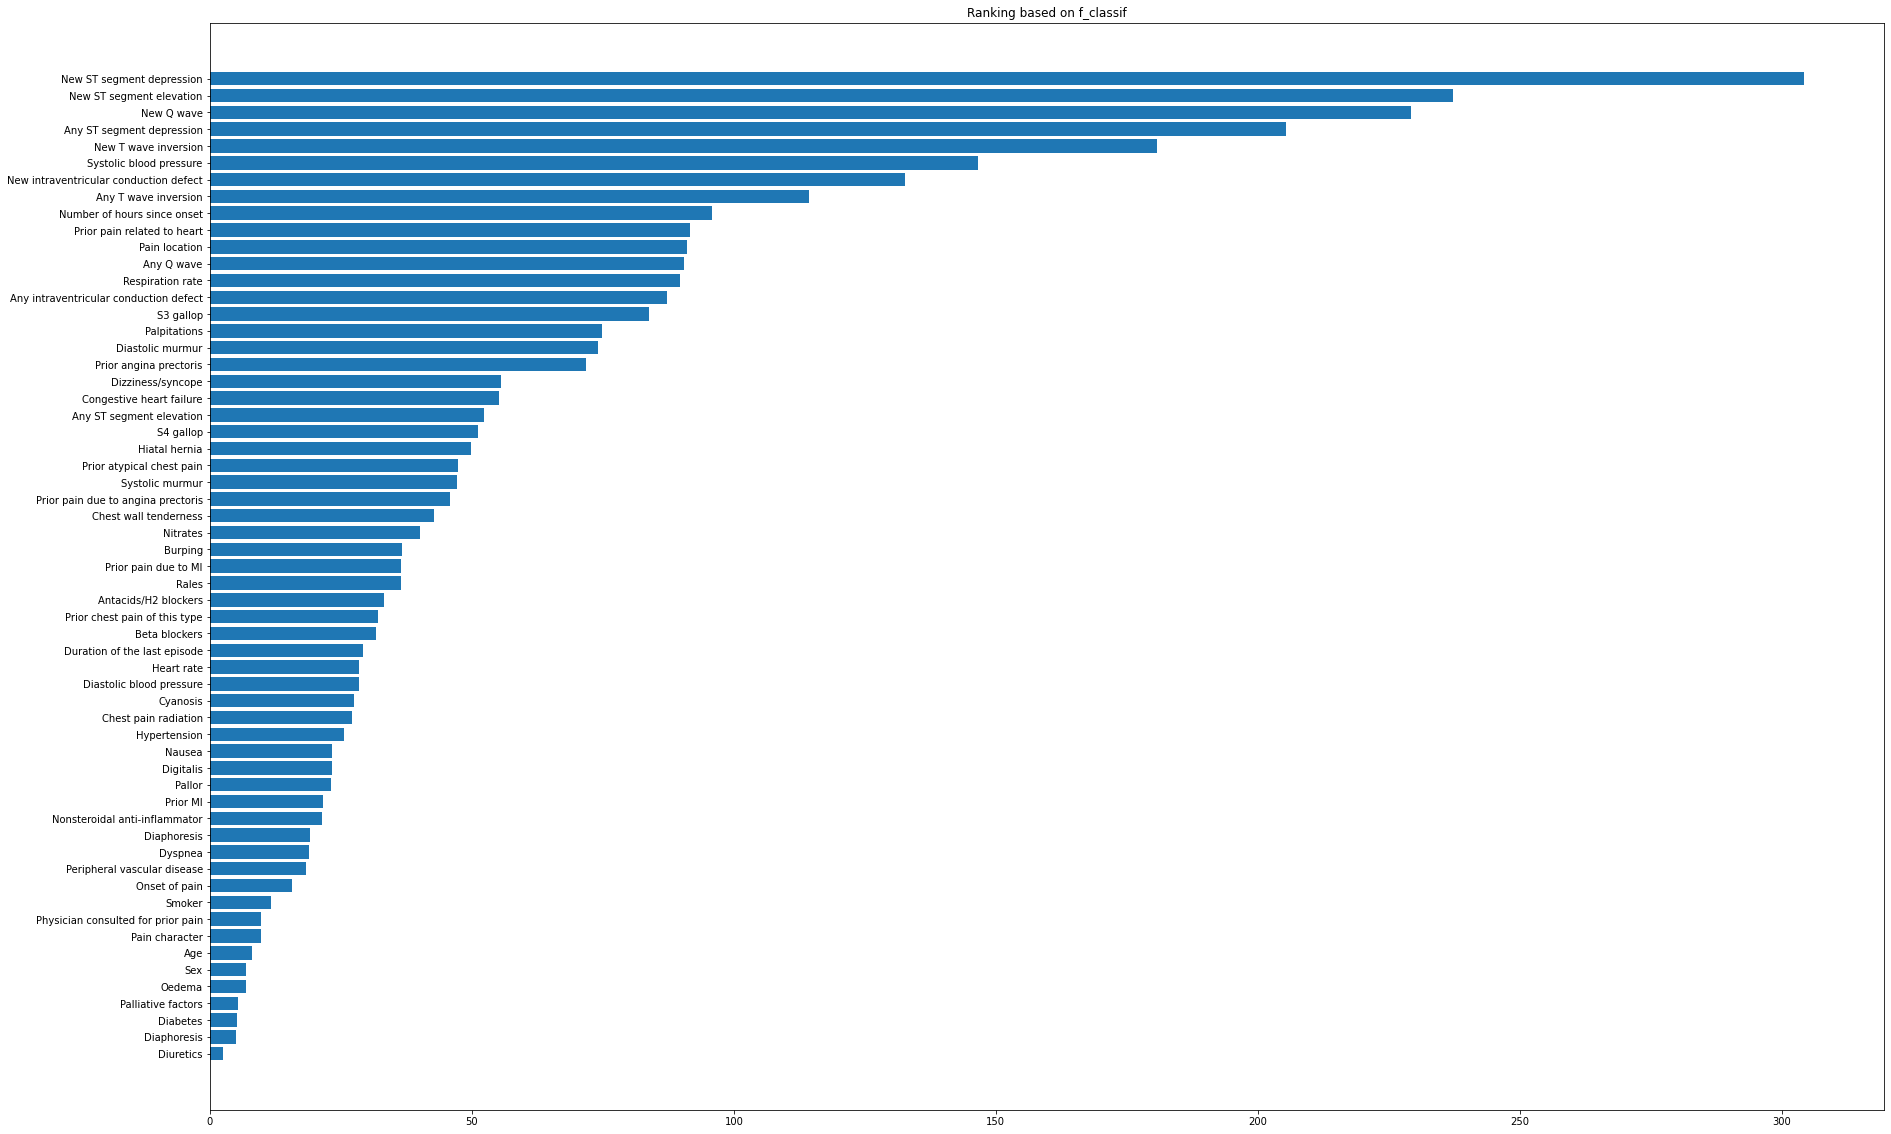

Features ranking after using chi2 score function:
1. Systolic blood pressure 1980.23
2. Number of hours since onset 978.58
3. Pain location 340.52
4. New ST segment depression 223.47
5. New Q wave 200.26
6. New T wave inversion 193.4
7. New ST segment elevation 188.22
8. Any ST segment depression 177.0
9. New intraventricular conduction defect 159.89
10. Any T wave inversion 151.67
11. Respiration rate 120.3
12. Diastolic murmur 117.16
13. Any intraventricular conduction defect 117.1
14. Prior angina prectoris 116.64
15. Chest pain radiation 114.72
16. Heart rate 109.56
17. Any Q wave 108.82
18. S3 gallop 105.09
19. Prior pain related to heart 101.63
20. Prior pain due to MI 89.17
21. S4 gallop 87.11
22. Prior pain due to angina prectoris 85.87
23. Congestive heart failure 85.27
24. Systolic murmur 84.5
25. Hiatal hernia 83.61
26. Dizziness/syncope 83.29
27. Palpitations 82.35
28. Beta blockers 79.73
29. Diastolic blood pressure 78.56
30. Nitrates 76.57
31. Any ST segment elevation 75.

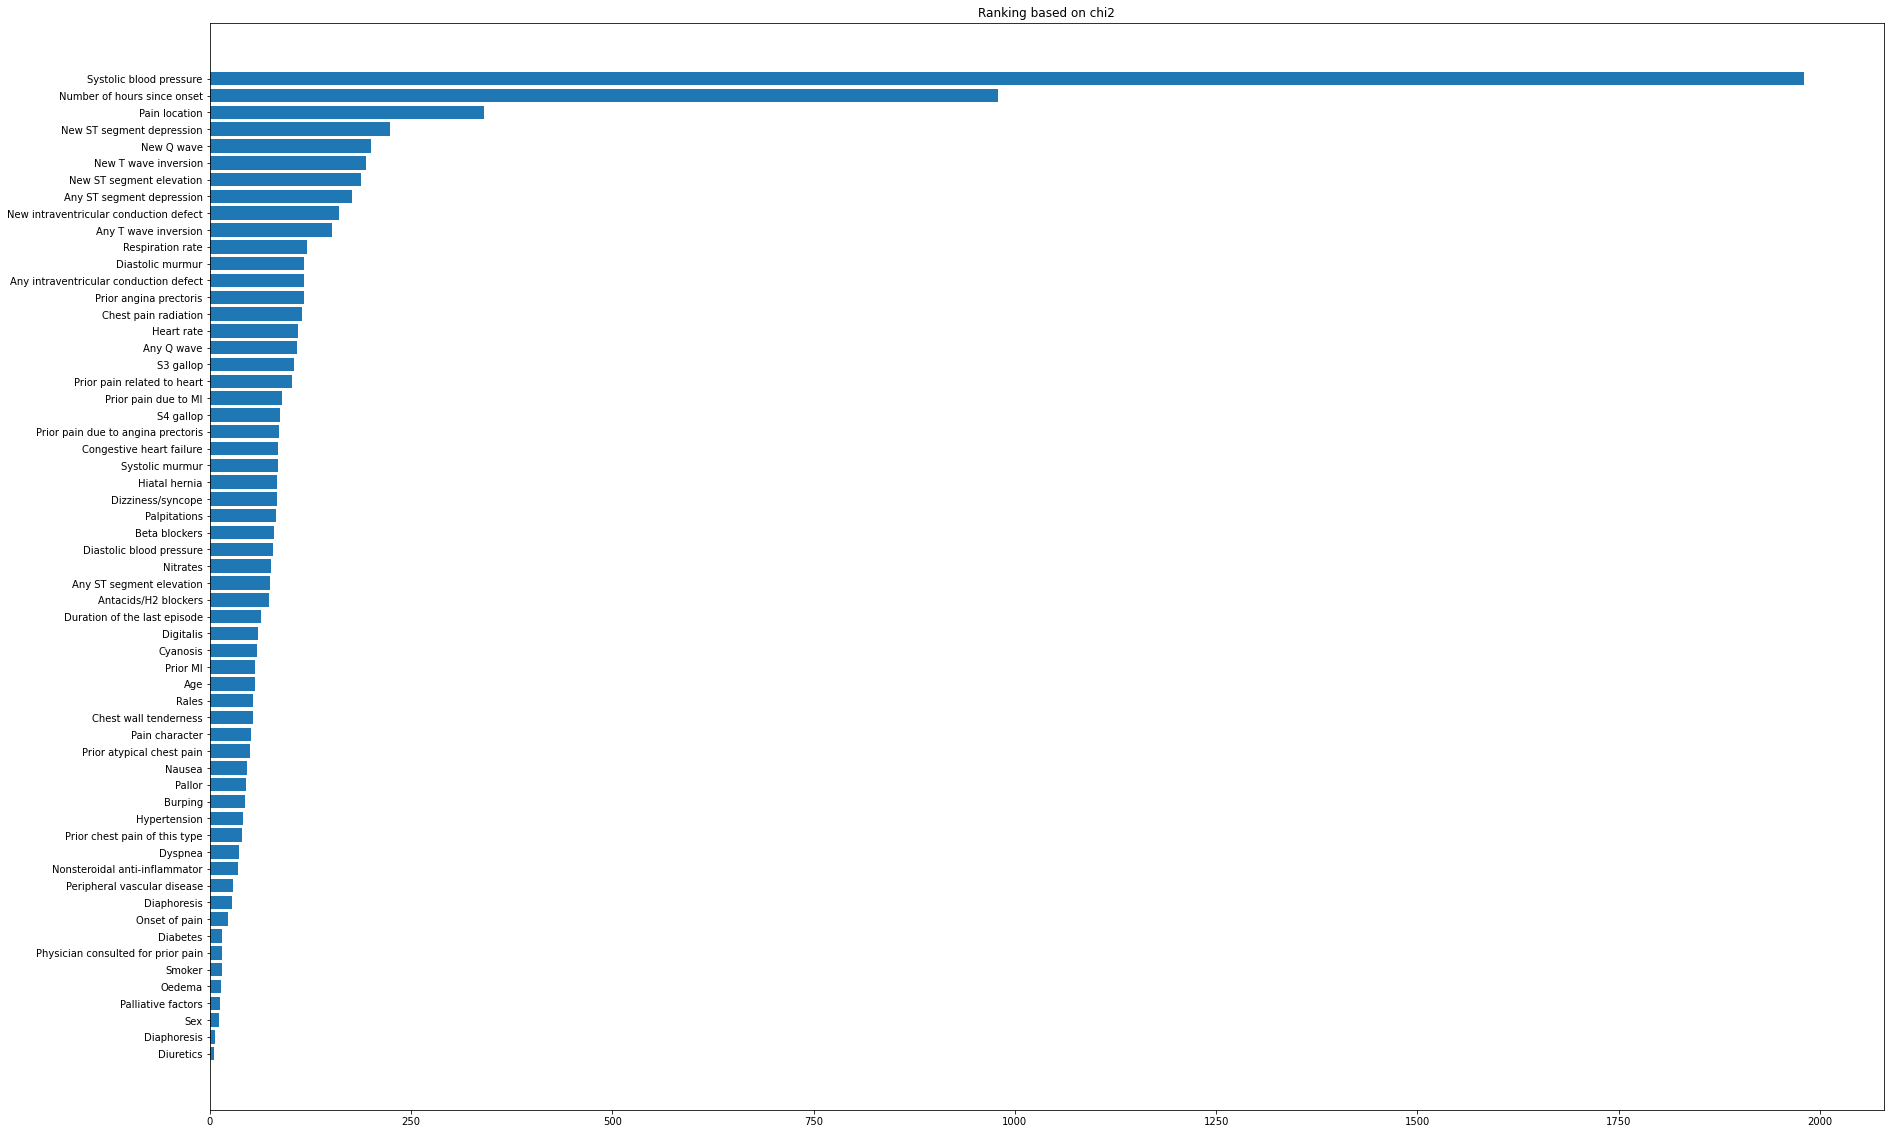

In [6]:
from sklearn.feature_selection import chi2, f_classif

x = dataset.drop('Class', axis=1)
y = dataset['Class']
# f_classif: ANOVA test (F-value between label/feature for regression tasks)
features_ranking_classif = build_features_ranking(x, y, f_classif)
print_features_ranking_with_plot(features_ranking_classif, 'f_classif')
# chi-squared stats of non-negative features for classification tasks.
features_ranking_chi = build_features_ranking(x, y, chi2)
print_features_ranking_with_plot(features_ranking_chi, 'chi2')

# Evaluation of the classifier with cross validation


In [7]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

def evaluate_and_get_classifiers(classfier,features_set,y):
  # prepare the cross-validation procedure
  validator = RepeatedKFold(n_splits=2, n_repeats=5, random_state=0)
  # evaluate model
  cv_results = cross_validate(classfier,features_set,y,cv=validator,scoring='accuracy',return_estimator=True)
  # report performance
  mean = np.mean(cv_results['test_score'])
  return (mean,cv_results['estimator'])

# Confusion matrix

## Confusion matrix create by data from RKNFold

In [8]:
from sklearn.metrics import confusion_matrix
from functools import reduce 

def build_and_plot_confusion_matrix(best_result,feature_names,best_classifiers):
  # store all of the confusion matrixes
  confusion_matrixes = []
  # reproduce same dataset when cross validating
  features_count_int = int(best_result['features_count'])
  feature_names_for_run = feature_names[:features_count_int]
  x = dataset.drop(dataset.columns.difference(feature_names_for_run), 1)
  y = dataset['Class']
  # construct same splits as used on training in cross validation
  rkf = RepeatedKFold(n_splits=2, n_repeats=5, random_state=0)
  # index for selecting classifiers
  index = 0
  for train_index, test_index in rkf.split(x):
    # extract the training and test set
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # get the correct classifier from best_classifiers array (this is the best set of classifiers from cross validation)
    classifer_for_run=best_classifiers[index]
    # fit the classifier
    classifer_for_run.fit(x_train, y_train)
    # predict on the test set
    y_pred = classifer_for_run.predict(x_test)
    # calculate the confusion_matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    # append to rest
    confusion_matrixes.append(conf_matrix)
    # increment the index
    index = index + 1
    
  # calculate the total sum of confusion matrixes
  final_matrix = reduce(lambda x,y: x + y, confusion_matrixes)
  normalized_matrix = final_matrix.astype('float') / final_matrix.sum(axis=1)[:, np.newaxis]
  # prepare confusion matrixes
  df_cm = pd.DataFrame(final_matrix,dataset_classes.values(),dataset_classes.values())
  df_cm_normalized = pd.DataFrame(normalized_matrix,dataset_classes.values(),dataset_classes.values())
  # plot final matrix & normlized matrix
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(45,10))
  fig.suptitle('Confusion matrixes')
  ax1.set_title('Confusion matrix')
  ax2.set_title('Normalized confusion matrix')
  sns.heatmap(df_cm, annot=True, fmt='d', ax=ax1)
  sns.heatmap(df_cm_normalized, annot=True, ax=ax2)

# Experiment

   features_count  neighbours_count     metric  mean_accuracy
0               1                 1  euclidean       0.511654
1               2                 1  euclidean       0.501487
2               3                 1  euclidean       0.502142
3               4                 1  euclidean       0.528111
4               5                 1  euclidean       0.524113
max accuracy: 0.739621088938162


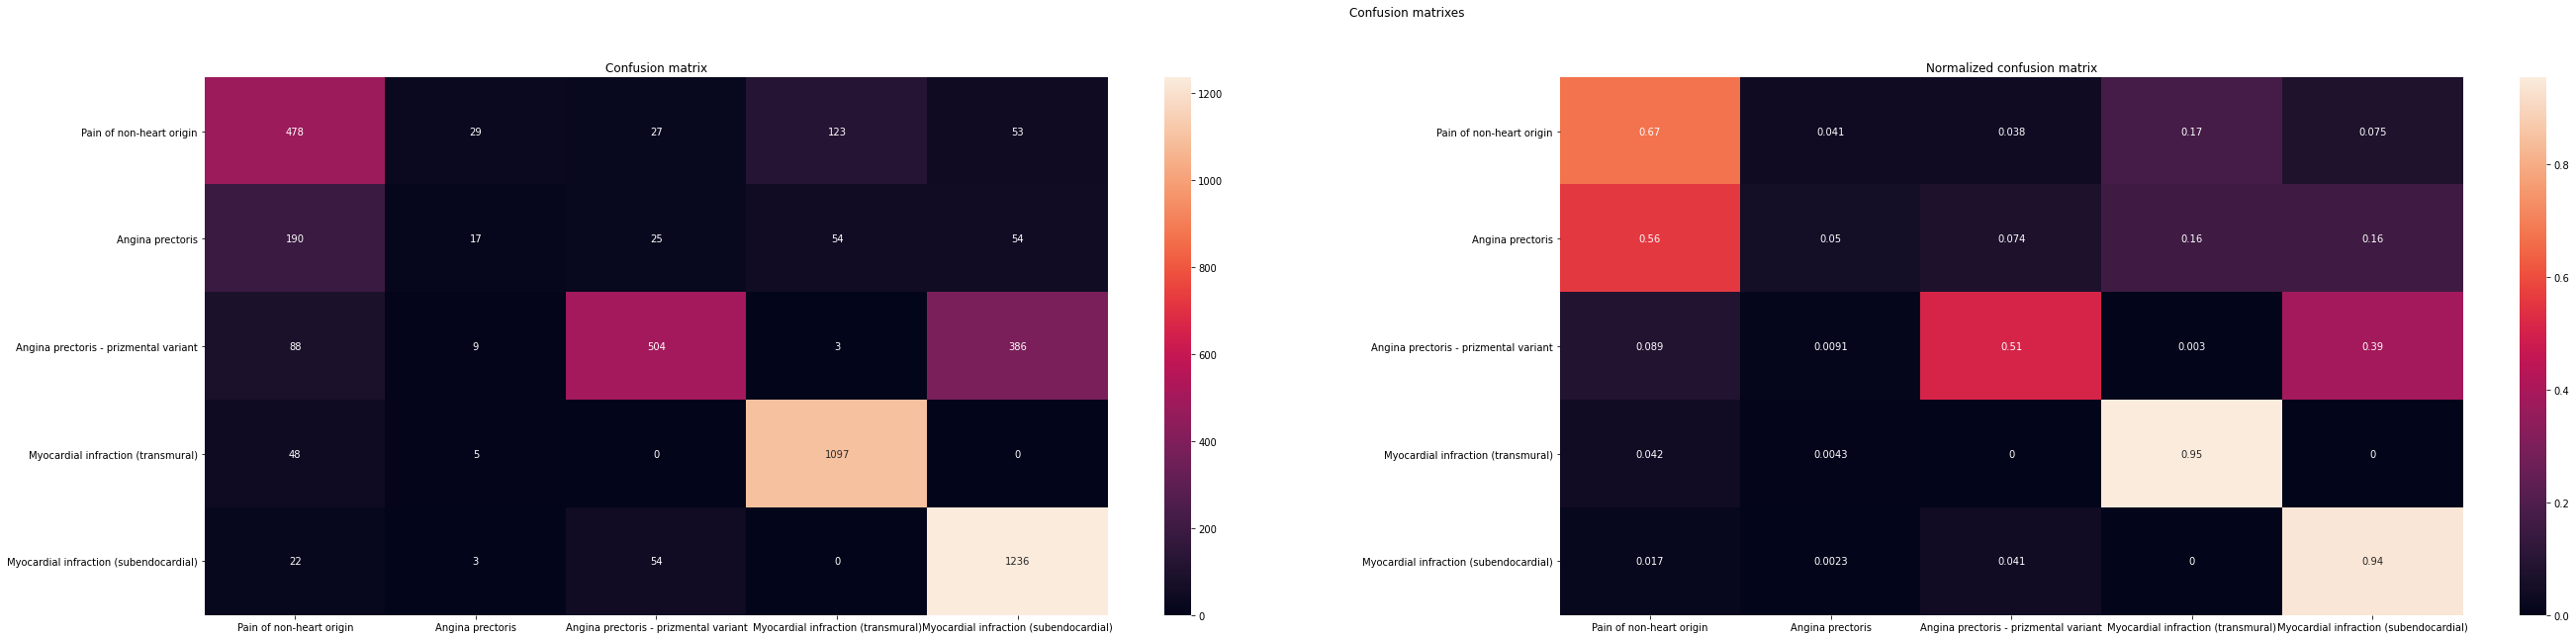

In [9]:
from sklearn.neighbors import KNeighborsClassifier

x = dataset.drop('Class', axis=1)
y = dataset['Class']

features_ranking = build_features_ranking(x,y,f_classif)
feature_names = [feature[0] for feature in features_ranking] # convert to only class names

number_of_neighbours=(1,5,10)
metrics=('euclidean','manhattan')

result_columns = ['features_count', 'neighbours_count', 'metric', 'mean_accuracy']
results = []
best_classifiers = []
maximum_features = 59

# for each metric
for metric in metrics:
  # for each k neighbours
  for neighbours_count in number_of_neighbours:
    # append features on the way
    for features_count in range(1, maximum_features+1):
      # include in the dataset only features selected from ranking in given run
      x = dataset.drop(dataset.columns.difference(feature_names[:features_count]), 1)
      # construct the classifier
      knn_classifier = KNeighborsClassifier(n_neighbors=neighbours_count, metric=metric)
      # perfomr the Cross validation process and get results
      current_result_mean, classifiers = evaluate_and_get_classifiers(knn_classifier,x,y)
      # save the best set of classifiers
      if all(result[3] <= current_result_mean for result in results):
        best_classifiers = classifiers
      results.append([features_count, neighbours_count, metric, current_result_mean])


# convert results to dataframe
results_df = pd.DataFrame(results)
results_df.columns = result_columns

max_accuracy = results_df['mean_accuracy'].max()
best_result_record = results_df[results_df['mean_accuracy'] == max_accuracy]

print(best_result_record)

print(f"max accuracy: {max_accuracy}")
build_and_plot_confusion_matrix(best_result_record,feature_names,best_classifiers)

Analiza statystyczna wyników (pytanie czy średnich pomiędzy całymi iteracjami czy wyników w danym obiegu KFolda).

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(results_df)

     features_count  neighbours_count     metric  mean_accuracy
0                 1                 1  euclidean       0.511654
1                 2                 1  euclidean       0.501487
2                 3                 1  euclidean       0.502142
3                 4                 1  euclidean       0.528111
4                 5                 1  euclidean       0.524113
5                 6                 1  euclidean       0.565383
6                 7                 1  euclidean       0.556280
7                 8                 1  euclidean       0.562716
8                 9                 1  euclidean       0.578475
9                10                 1  euclidean       0.585137
10               11                 1  euclidean       0.603108
11               12                 1  euclidean       0.607104
12               13                 1  euclidean       0.627292
13               14                 1  euclidean       0.629515
14               15                 1  e